# Deep Learning Crash Course: From logistic regression to Deep Neural Networks

This notebook covers two examples of classification task as seen in the slides.

- First, we develop of a simple logistic regression to classify between drawings.

- Second, we develop an improved example based on deep neural networks.

- Finally, we try to attack that model with a Deep Generative Adversarial Network. Based on the complexity the results obtained are different.


The goal is to see how logistic regression is the base for Deep Neural Networks, and how its combination in more complex architectures improves the accuracy of the model.


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
import time
from IPython import display

To download the different datasets of drawings that we will use, you can execute the cli below.

In [2]:
! curl https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/apple.npy -o apple.npy
! curl https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy -o book.npy
! curl https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/basketball.npy -o basketball.npy
! curl https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bee.npy -o bee.npy
! curl https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/hexagon.npy -o hexagon.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  108M  100  108M    0     0  80.6M      0  0:00:01  0:00:01 --:--:-- 80.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 89.2M  100 89.2M    0     0  82.3M      0  0:00:01  0:00:01 --:--:-- 82.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  100M  100  100M    0     0  84.5M      0  0:00:01  0:00:01 --:--:-- 84.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 90.3M  100 90.3M    0     0  54.3M      0  0:00:01  0:00:01 --:--:-- 54.3M
  % Total    % Received % Xferd  Average Speed   Tim

The code below is auxiliary. We use it to plot different images in the Jupyter Notebook

DATASET: apple (144722, 28, 28, 1)


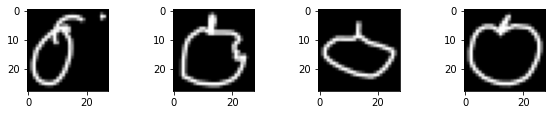

DATASET: book (119364, 28, 28, 1)


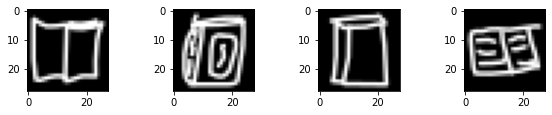

DATASET: hexagon (142435, 28, 28, 1)


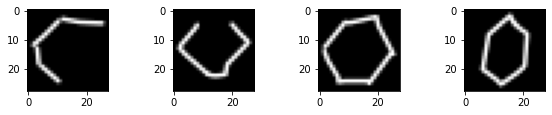

DATASET: bee (120890, 28, 28, 1)


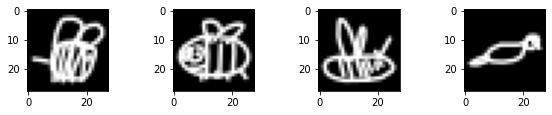

DATASET: basketball (133793, 28, 28, 1)


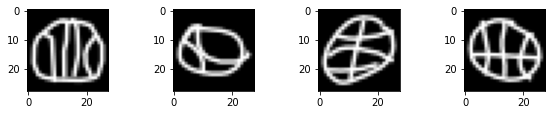

In [31]:
def preprocess_real_samples(samples):
    samples = samples.astype('float32').reshape(-1, 28, 28, 1)
    samples = (samples - samples.min()) / (samples.max() - samples.min())
    return samples

def plot_images(x, save = False, savefile="img.png"):
    w=10
    h=1.5
    fig=plt.figure(figsize=(w, h))
    columns = 4
    rows = 1
    for i in range(1, columns*rows +1):
        img = np.random.randint(x.shape[0])
        fig.add_subplot(rows, columns, i)
        plt.imshow(x[i - 1, :, :, 0], cmap='gray')
    if save:
        plt.savefig(savefile)
    plt.show()
    plt.close()
    
def sample_plots():
    for i in ['apple', 'book', 'hexagon', 'bee', 'basketball']:
        dataset = preprocess_real_samples(np.load('%s.npy'%(i)))
        print("DATASET: %s " % (i) + str(dataset.shape))
        plot_images(dataset)
sample_plots()

The code below is used to prepare a balanced dataset. One of the key points of Deep Learning is having a balanced dataset based on the Deep Learning task that we want to execute. In this example, given the classification of apple drawings, we need to have as many apple drawings as non-apple drawings.

When doing Machine Learning, we usually divide the input dataset in training and test. In general, we want the test dataset to have a sufficient population to check the accuracy. Usually, we can use 60\% - 40\% in Machine Learning. When the training dataset is sufficiently large, we can reduce it. 

In this case we use 90\% - 10\%, because the training dataset has 25000 samples and 10\% encompases 2500 samples (sufficient to test).

In [4]:
def prepare_dataset(label='apple', others=['book', 'hexagon', 'bee', 'basketball']):
    
    x = preprocess_real_samples(np.load('%s.npy'%(label)))
    y = np.array([1] * len(x))
    num_samples = x.shape[0]
    others_samples = num_samples // len(others)
    for i in others:
        dataset = preprocess_real_samples(np.load('%s.npy'%(i)))
        entries = np.random.choice(len(dataset), size=others_samples, replace=False)
        print(len(entries), others_samples, len(set(entries.tolist())))
        x = np.concatenate([x, dataset[entries]], axis=0)
        y = np.concatenate([y, np.array([0] * len(entries))], axis=0)
    
    entries = np.random.choice(len(x), size=len(x), replace=False)
    x = x[entries]
    y = y[entries]
    x_train, y_train, x_test, y_test = (lambda t: (x[:t], y[:t], x[t:], y[t:]))(int(len(x) * 0.9))
    return x_train, y_train, x_test, y_test
                               
x_train, y_train, x_test, y_test = prepare_dataset()
# We define ROWS, COLS and CHANNELS as the values extracted from the first entry of the dataset.
ROWS, COLS, CHANNELS = x_train.shape[1:]

36180 36180 36180
36180 36180 36180
36180 36180 36180
36180 36180 36180


First, we try a logistic regression model. It is made of:
- `Flatten` layer: To linearize the 3 dimensional matrices representing the pictures.
- `Dense` layer (with one unit): Equivalent to the logistic regression. Additionally, the dendse layer contains a sigmoid activation function

In [32]:
def get_lr_model():
    model = Sequential()
    model.add(Flatten(input_shape=(ROWS,COLS,CHANNELS))) 
    # ^ Linearizes the array
    model.add(Dense(units=1,activation="sigmoid")) 
    # ^ 1 neuron Neural Network = Logistic Regression
    return model

logistic_regression = get_lr_model()

Here we compile the model to use the binary_cross_entropy. 

The formula is given by: $L(y, y') = y' \cdot log(y) + (1 - y') \cdot log(x)$

The optimizer regulates how the update of the hyperparameters $\theta_i$ affects them per iteration of gradient descent.

In [33]:
logistic_regression.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
logistic_regression.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 785       
                                                                 
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________


The fit function receives the training and test sets.

The epochs define the number of iterations that we make the whole dataset.

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
hist = logistic_regression.fit(x_train, y_train, 
          epochs=5, # If we put more epochs, we have more accuracy
          validation_data=(x_test, y_test), 
          verbose=1)

Epoch 1/5


2022-05-12 07:32:43.986509: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 816918592 exceeds 10% of free system memory.


8141/8141 [==============================] - 13s 2ms/step - loss: 0.1626 - accuracy: 0.9494 - val_loss: 0.1533 - val_accuracy: 0.9506
Epoch 2/5
8141/8141 [==============================] - 12s 1ms/step - loss: 0.1554 - accuracy: 0.9513 - val_loss: 0.1537 - val_accuracy: 0.9517
Epoch 3/5
8141/8141 [==============================] - 12s 1ms/step - loss: 0.1550 - accuracy: 0.9516 - val_loss: 0.1542 - val_accuracy: 0.9496
Epoch 4/5
8141/8141 [==============================] - 12s 1ms/step - loss: 0.1548 - accuracy: 0.9516 - val_loss: 0.1537 - val_accuracy: 0.9503
Epoch 5/5
8141/8141 [==============================] - 12s 2ms/step - loss: 0.1546 - accuracy: 0.9515 - val_loss: 0.1531 - val_accuracy: 0.9512


This second model is a variation of the first one. The model is composed in this case of three layers.

It also includes the `Flatten` layer that linearices the three dimensional matrix.

Also, it introduces a `Dense` Layer with 100 units / neurons. As we covered, this could also be considered 100 logistic regressions.

These 100 units give their output to the output `Dense` Layer with 1 unit/neuron.

In [35]:
def get_model():
    model = Sequential()
    model.add(Flatten(input_shape=(ROWS,COLS,CHANNELS))) 
    # ^ Linearizes the array
    model.add(Dense(units=100, activation="leaky_relu"))
    # ^ 100 neuron layer
    model.add(Dense(units=1,activation="sigmoid")) 
    # ^ 1 neuron Neural Network = Logistic Regression
    return model

dense_model = get_model()

In [36]:
dense_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
dense_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               78500     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 78,601
Trainable params: 78,601
Non-trainable params: 0
_________________________________________________________________


In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
hist = dense_model.fit(x_train, y_train, 
          epochs=5, # If we put more epochs, we have more accuracy
          validation_data=(x_test, y_test), 
          verbose=1)

Epoch 1/5


2022-05-12 07:34:53.450024: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 816918592 exceeds 10% of free system memory.


8141/8141 [==============================] - 17s 2ms/step - loss: 0.0988 - accuracy: 0.9679 - val_loss: 0.0799 - val_accuracy: 0.9741
Epoch 2/5
8141/8141 [==============================] - 16s 2ms/step - loss: 0.0749 - accuracy: 0.9758 - val_loss: 0.0725 - val_accuracy: 0.9771
Epoch 3/5
8141/8141 [==============================] - 16s 2ms/step - loss: 0.0665 - accuracy: 0.9783 - val_loss: 0.0689 - val_accuracy: 0.9779
Epoch 4/5
8141/8141 [==============================] - 16s 2ms/step - loss: 0.0612 - accuracy: 0.9800 - val_loss: 0.0663 - val_accuracy: 0.9783
Epoch 5/5
8141/8141 [==============================] - 16s 2ms/step - loss: 0.0573 - accuracy: 0.9815 - val_loss: 0.0692 - val_accuracy: 0.9788


#### Attacking a Convolutional Neural Network Model

In the following example, we try to attack a neural network model, that is based on a convolutional network. For that, we use a specific use case of a Generative Adversarial Network training.

The Convolutional Neural Network (CNN), is based on blocks of Convolutional (`Conv2d`), LeakyReLU (`LeakyReLU`) and dropout (`Dropout`) layers for model stability.

In [11]:


def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


discriminator = make_discriminator_model()

We use the same parametrization for the model training. A `BinaryCrossentropy` loss and the `Adam` optimizer.

In [12]:
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 6272)             

We consider the model to be previously trained, and only having access to query results from it.

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
hist = discriminator.fit(x_train, y_train, 
          epochs=5, # If we put more epochs, we have more accuracy
          validation_data=(x_test, y_test), 
          verbose=1)

Epoch 1/5


2022-05-11 17:18:25.198731: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 816918592 exceeds 10% of free system memory.


8141/8141 [==============================] - 85s 10ms/step - loss: 1.2297 - accuracy: 0.9126 - val_loss: 0.7799 - val_accuracy: 0.9484
Epoch 2/5
8141/8141 [==============================] - 82s 10ms/step - loss: 1.0745 - accuracy: 0.9293 - val_loss: 0.9053 - val_accuracy: 0.9409
Epoch 3/5
8141/8141 [==============================] - 82s 10ms/step - loss: 1.0363 - accuracy: 0.9323 - val_loss: 0.8147 - val_accuracy: 0.9469
Epoch 4/5
8141/8141 [==============================] - 82s 10ms/step - loss: 1.1065 - accuracy: 0.9279 - val_loss: 1.1127 - val_accuracy: 0.9277
Epoch 5/5
8141/8141 [==============================] - 82s 10ms/step - loss: 1.2219 - accuracy: 0.9202 - val_loss: 0.9033 - val_accuracy: 0.9411


We make a generator model that will input random noise, and output images based on the needed input (24, 24). It has the shape of a convolutional neural network but reversed. We come from the output, and go back to an input image.

In [14]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

We create the models and a combination of those that we name `gan_model`. It uses the output of the previous model to learn the correlations needed to replicate the shapes that work on that model.

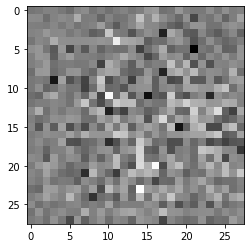

In [15]:
generator = make_generator_model()
generator.compile(loss='binary_crossentropy', 
                optimizer='rmsprop')

def gan_model(generator, discriminator):
    discriminator.trainable=False
    gan_input = layers.Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan= tf.keras.Model(inputs=gan_input, outputs=gan_output)
    #gan.compile(loss='binary_crossentropy', optimizer='adam')
    gan.compile(loss='binary_crossentropy', 
                optimizer='rmsprop')
    return gan

gan = gan_model(generator, discriminator)
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [16]:
def generator_loss(fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

We need to define a special training loop based on a GAN training loop, in which the generator will use the output of the images that it generates, to learn the correlations.

In [18]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    gan.train_on_batch(noise, np.ones((BATCH_SIZE, 1)))    

The code below makes the image batches for the training

In [19]:
def train(dataset, epochs):
    print("Starting Training")
    for epoch in range(epochs):
        start = time.time()
        print("EPOCH %d" %(epoch))
        count = 0
        for image_batch in dataset:
            if count % 100 == 0:
                print("BATCH: %d"%(count))
            count += 1
            train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch + 1,
                             seed)
        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:

            checkpoint.save(file_prefix = checkpoint_prefix)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

Below we see the training based with the checkpoints and image generation to check progress.

In [20]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [21]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('img/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

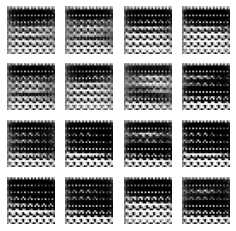

In [22]:
BATCH_SIZE = 32
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
train(x_train[:64], EPOCHS)

In [23]:
noise = tf.random.normal([BATCH_SIZE, noise_dim])
generated_images = generator(noise, training=True)

In [29]:
import PIL, imageio, glob
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('img/image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    